# Task 2  EDA

Load data, plot prices, analyze log returns, and test stationarity.

> Dev note: run `black src/time_series.py`, then `git add -A`, then `pre-commit run --all-files` before commit.

In [1]:
# Imports
import sys
from pathlib import Path

ROOT = Path('..').resolve()
sys.path.append(str(ROOT))

from src.data_preprocessing import load_brent_data, calculate_returns, test_stationarity
from src.visualization import setup_plotting_style, plot_price_series, plot_log_returns, plot_rolling_volatility

setup_plotting_style()

df = load_brent_data(str(ROOT / 'data' / 'raw' / 'BrentOilPrices.csv'))
df.head()

Matplotlib is building the font cache; this may take a moment.


,Date,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


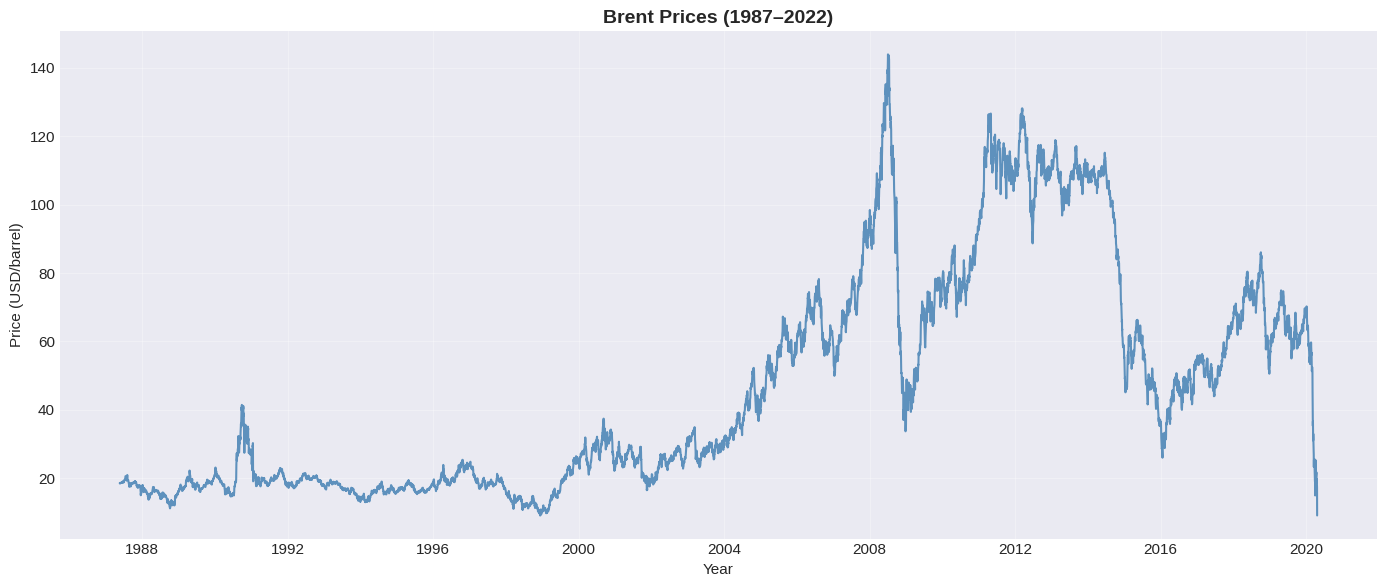

In [2]:
# Raw price series
fig = plot_price_series(df, title='Brent Prices (1987–2022)')
fig.tight_layout()

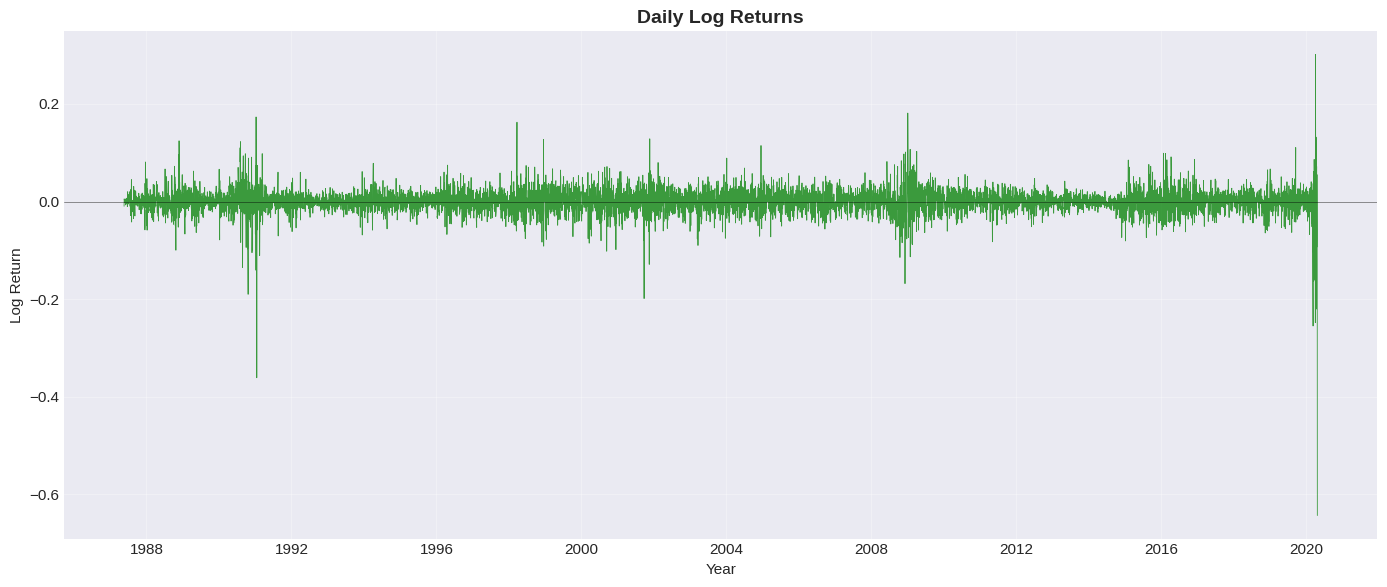

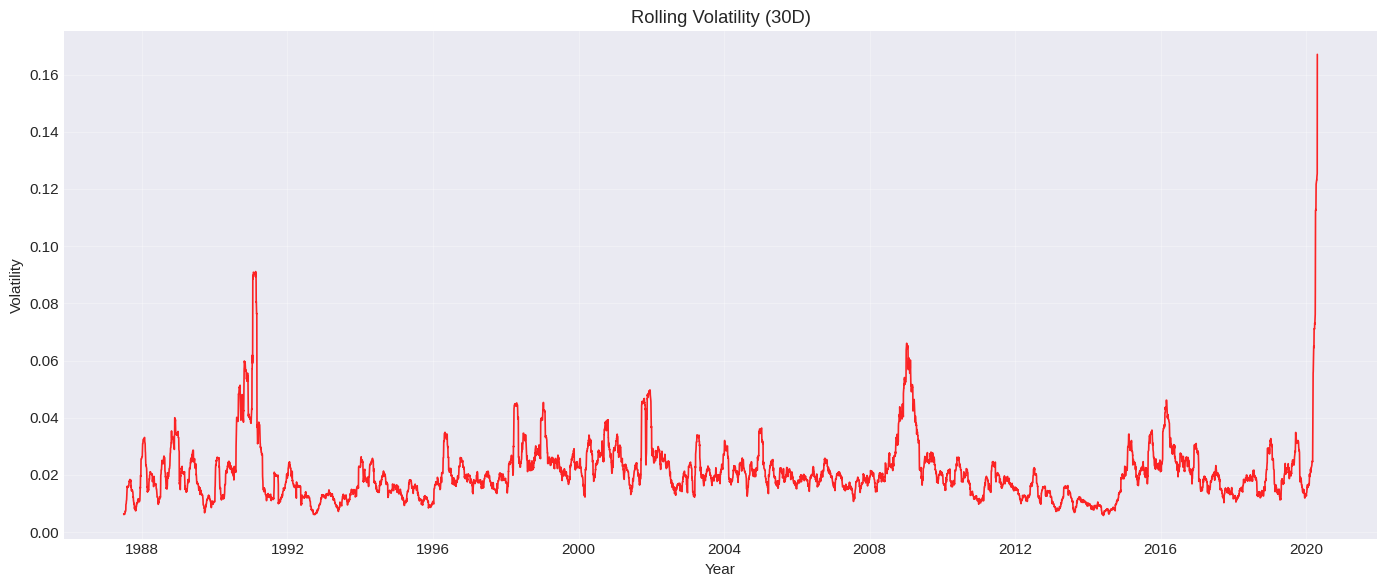

In [3]:
# Log returns + volatility
df_r = calculate_returns(df)

fig = plot_log_returns(df_r, title='Daily Log Returns')
fig.tight_layout()

fig = plot_rolling_volatility(df_r, window=30, title='Rolling Volatility')
fig.tight_layout()

In [4]:
# Stationarity tests
raw_stats = test_stationarity(df['Price'])
log_stats = test_stationarity(df_r['Log_Returns'])

raw_stats, log_stats

({'adf_stat': -2.0186531355212654,
  'p_value': 0.27845471012993234,
  'is_stationary': False},
 {'adf_stat': -12.60308859826176,
  'p_value': 1.7191109143088885e-23,
  'is_stationary': True})